In [110]:
from pathlib import Path
import pandas as pd
import sys
import numpy as np
import torch
import random
import os

def torch_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed) # if use multi-GPU 
    # CUDA randomness
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    np.random.seed(random_seed)
    random.seed(random_seed)
    os.environ['PYTHONHASHSEED'] = str(random_seed)

%matplotlib inline

In [111]:
import matplotlib.pyplot as plt

def check_graph(xs, att=None, piece=1, threshold=None):
    """
    anomaly score and anomaly label visualization

    Parameters
    ----------
    xs : np.ndarray
        anomaly scores
    att : np.ndarray
        anomaly labels
    piece : int
        number of figures to separate
    threshold : float(default=None)
        anomaly threshold

    Return
    ------
    fig : plt.figure
    """
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(12, 4 * piece))
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = np.arange(L, R)
        if piece == 1:
            ax = axs
        else:
            ax = axs[i]
        ax.plot(xticks, xs[L:R], color='#0C090A')
        ymin, ymax = ax.get_ylim()
        ymin = 0
        ax.set_ylim(ymin, ymax)
        if len(xs[L:R]) > 0 and att is not None:
            ax.vlines(xticks[np.where(att[L:R] == 1)], ymin=ymin, ymax=ymax, color='#FED8B1',
                          alpha=0.6, label='true anomaly')
        ax.plot(xticks, xs[L:R], color='#0C090A', label='anomaly score')
        if threshold is not None:
            ax.axhline(y=threshold, color='r', linestyle='--', alpha=0.8, label=f'threshold:{threshold:.4f}')
        ax.legend()

    return fig

In [112]:
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, average_precision_score
from collections import Counter

def calc_point2point(predict, actual):
    """
    calculate f1 score by predict and actual.
    Args:
        predict (np.ndarray): the predict label
        actual (np.ndarray): np.ndarray
    """
    TP = np.sum(predict * actual)
    TN = np.sum((1 - predict) * (1 - actual))
    FP = np.sum(predict * (1 - actual))
    FN = np.sum((1 - predict) * actual)
    precision = TP / (TP + FP + 0.00001)
    recall = TP / (TP + FN + 0.00001)
    f1 = 2 * precision * recall / (precision + recall + 0.00001)
    return f1, precision, recall, TP, TN, FP, FN


def adjust_predicts(score, label,
                    threshold=None,
                    pred=None,
                    calc_latency=False):
    """
    Calculate adjusted predict labels using given `score`, `threshold` (or given `pred`) and `label`.
    Args:
        score (np.ndarray): The anomaly score
        label (np.ndarray): The ground-truth label
        threshold (float): The threshold of anomaly score.
            A point is labeled as "anomaly" if its score is lower than the threshold.
        pred (np.ndarray or None): if not None, adjust `pred` and ignore `score` and `threshold`,
        calc_latency (bool):
    Returns:
        np.ndarray: predict labels
    """
    if len(score) != len(label):
        raise ValueError("score and label must have the same length")
    score = np.asarray(score)
    label = np.asarray(label)
    latency = 0
    if pred is None:
        predict = score > threshold
    else:
        predict = pred
    actual = label > 0.1
    anomaly_state = False
    anomaly_count = 0
    for i in range(len(score)):
        if actual[i] and predict[i] and not anomaly_state:
                anomaly_state = True
                anomaly_count += 1
                for j in range(i, 0, -1):
                    if not actual[j]:
                        break
                    else:
                        if not predict[j]:
                            predict[j] = True
                            latency += 1
        elif not actual[i]:
            anomaly_state = False
        if anomaly_state:
            predict[i] = True
    if calc_latency:
        return predict, latency / (anomaly_count + 1e-4)
    else:
        return predict


def PA_percentile(score, label,
                  threshold=None,
                  pred=None,
                  K=100,
                  calc_latency=False):
    """
    Calculate adjusted predict labels using given `score`, `threshold` (or given `pred`) and `label`.
    Args:
        score (np.ndarray): The anomaly score
        label (np.ndarray): The ground-truth label
        threshold (float): The threshold of anomaly score.
            A point is labeled as "anomaly" if its score is lower than the threshold.
        pred (np.ndarray or None): if not None, adjust `pred` and ignore `score` and `threshold`,
        calc_latency (bool):
    Returns:
        np.ndarray: predict labels
    """
    if len(score) != len(label):
        raise ValueError("score and label must have the same length")
    score = np.asarray(score)
    label = np.asarray(label)
    latency = 0
    if pred is None:
        predict = score > threshold
    else:
        predict = pred
    actual = label > 0.1
    anomaly_state = False
    anomaly_count = 0
    anomalies = []

    for i in range(len(actual)):
        if actual[i]:
            if not anomaly_state:
                anomaly_state = True
                anomaly_count += 1
                anomalies.append([i, i])
            else:
                anomalies[-1][-1] = i
        else:
            anomaly_state = False

    for i, [start, end] in enumerate(anomalies):
        collect = Counter(predict[start:end + 1])[1]
        anomaly_count += collect
        collect_ratio = collect / (end - start + 1)

        if collect_ratio * 100 >= K and collect > 0:
            predict[start:end + 1] = True
            latency += (end - start + 1) - collect

    if calc_latency:
        return predict, latency / (anomaly_count + 1e-4)
    else:
        return predict


def calc_seq(score, label, threshold, K=0, calc_latency=False):
    """
    Calculate f1 score for a score sequence
    """
    if calc_latency:
        roc_auc = roc_auc_score(label, score)
        auprc = average_precision_score(label, score)
        #predict, latency = adjust_predicts(score, label, threshold, calc_latency=calc_latency)
        predict, latency = PA_percentile(score, label, threshold, K=K, calc_latency=calc_latency)
        t = list(calc_point2point(predict, label))
        t.append(roc_auc)
        t.append(auprc)
        t.append(latency)
        return t
    else:
        roc_auc = roc_auc_score(label, score)
        auprc = average_precision_score(label, score)
        # predict = adjust_predicts(score, label, threshold, calc_latency=calc_latency)
        predict = PA_percentile(score, label, threshold, K=K, calc_latency=calc_latency)
        t = list(calc_point2point(predict, label))
        t.append(roc_auc)
        t.append(auprc)
        return t


def bf_search(score, label, start, end=None, step_num=1, display_freq=1, K=0, verbose=True) -> object:
    """
    Find the best-f1 score by searching best `threshold` in [`start`, `end`).
    Returns:
        list: list for results
        float: the `threshold` for best-f1
    """
    if step_num is None or end is None:
        end = start
        step_num = 1
    search_step, search_range, search_lower_bound = step_num, end - start, start
    if verbose:
        print("search range: ", search_lower_bound, search_lower_bound + search_range)
    threshold = search_lower_bound
    m = (-1., -1., -1.)
    m_t = 0.0
    for i in range(search_step):
        threshold += search_range / float(search_step)
        target = calc_seq(score, label, threshold, K=K, calc_latency=True)
        if target[0] > m[0]:
            m_t = threshold
            m = target
        if verbose and i % display_freq == 0:
            print("cur thr: ", threshold, target, m, m_t)
    return m, m_t

def bp_search(score, label, start, end=None, step_num=1, display_freq=1, K=0, verbose=True) -> object:
    """
    Find the best-precision score by searching best `threshold` in [`start`, `end`).
    Returns:
        list: list for results
        float: the `threshold` for best-precision
    """
    if step_num is None or end is None:
        end = start
        step_num = 1
    search_step, search_range, search_lower_bound = step_num, end - start, start
    if verbose:
        print("search range: ", search_lower_bound, search_lower_bound + search_range)
    threshold = search_lower_bound
    m = (-1., -1., -1.)
    m_t = 0.0
    for i in range(search_step):
        threshold += search_range / float(search_step)
        target = calc_seq(score, label, threshold, K=K, calc_latency=True)
        if target[1] > m[1]:
            m_t = threshold
            m = target
        if verbose and i % display_freq == 0:
            print("cur thr: ", threshold, target, m, m_t)
    return m, m_t

In [113]:
result = pd.read_csv('./Test_AD_results_Cathode.csv')

In [114]:
anomaly_score = result['score']
ground_truth = result['true_label']

### Best F1

In [115]:
# Best F1
(f1, precision, recall, _, _, _, _, AUROC, _, _), threshold = bf_search(
                                                                score = anomaly_score,
                                                                label = ground_truth,
                                                                start = min(anomaly_score), 
                                                                end = np.percentile(anomaly_score, 95), 
                                                                step_num = 10000,
                                                                K = 100, 
                                                                verbose = False
                                                                )

print(f'AUROC: {AUROC:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

AUROC: 0.5706, F1: 0.8287, Precision: 0.7081, Recall: 0.9989


In [116]:
pred = (anomaly_score>threshold).astype(int)

tn, fp, fn, tp = confusion_matrix(ground_truth, pred).ravel()
(tn, fp, fn, tp)

(0, 378, 1, 917)

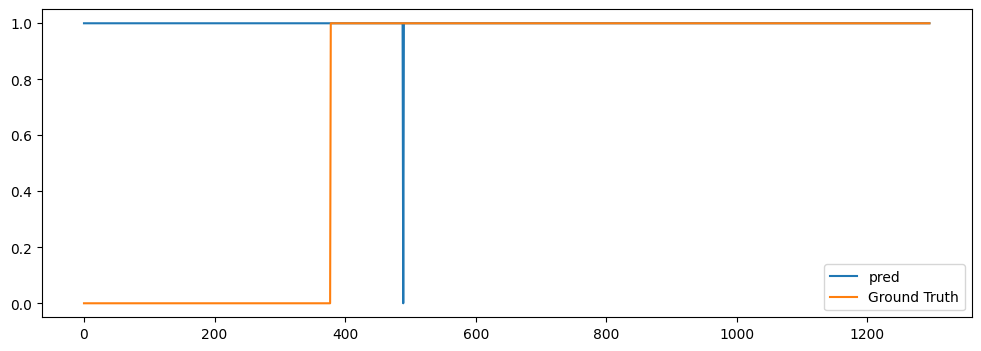

In [117]:
fig = plt.figure(figsize=(12, 4))
plt.plot(pred, label='pred')
plt.plot(ground_truth, label='Ground Truth')
plt.legend()
plt.show()

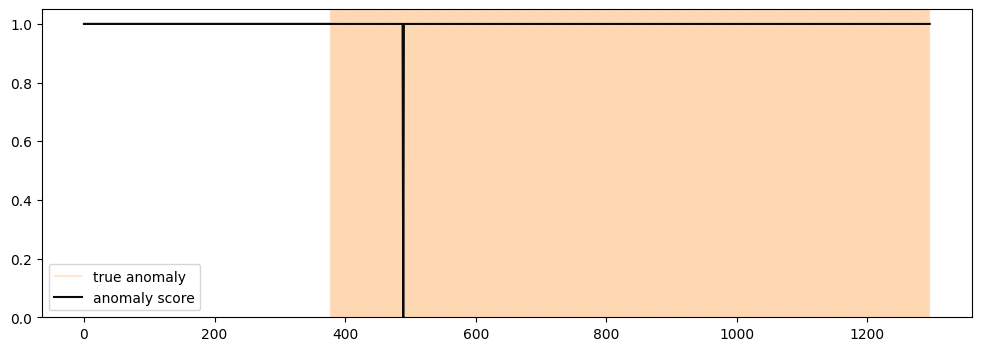

In [118]:
check_graph(pred, np.array(ground_truth))
plt.show()

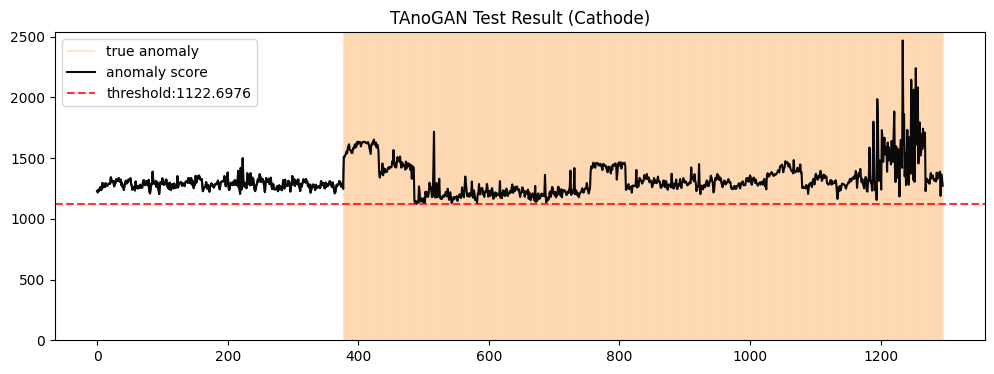

In [119]:
check_graph(anomaly_score, ground_truth,1,threshold)
plt.title('TAnoGAN Test Result (Cathode)')
plt.show()

In [120]:
bead_counter = []
for i in range(len(pred)//54):
    bead_counter.append(dict(Counter(pred[i*54: (i+1)*54])))
print(bead_counter)

[{1: 54}, {1: 54}, {1: 54}, {1: 54}, {1: 54}, {1: 54}, {1: 54}, {1: 54}, {1: 54}, {1: 53, 0: 1}, {1: 54}, {1: 54}, {1: 54}, {1: 54}, {1: 54}, {1: 54}, {1: 54}, {1: 54}, {1: 54}, {1: 54}, {1: 54}, {1: 54}, {1: 54}, {1: 54}]


### Best Precision

In [121]:
# Best Precision
(f1, precision, recall, _, _, _, _, AUROC, _, _), threshold = bp_search(
                                                                score = anomaly_score,
                                                                label = ground_truth,
                                                                start = min(anomaly_score), 
                                                                end = np.percentile(anomaly_score, 95), 
                                                                step_num = 10000,
                                                                K = 100, 
                                                                verbose = False
                                                                )

print(f'AUROC: {AUROC:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

AUROC: 0.5706, F1: 0.2105, Precision: 1.0000, Recall: 0.1176


In [122]:
pred = (anomaly_score>threshold).astype(int)

tn, fp, fn, tp = confusion_matrix(ground_truth, pred).ravel()
(tn, fp, fn, tp)

(378, 0, 810, 108)

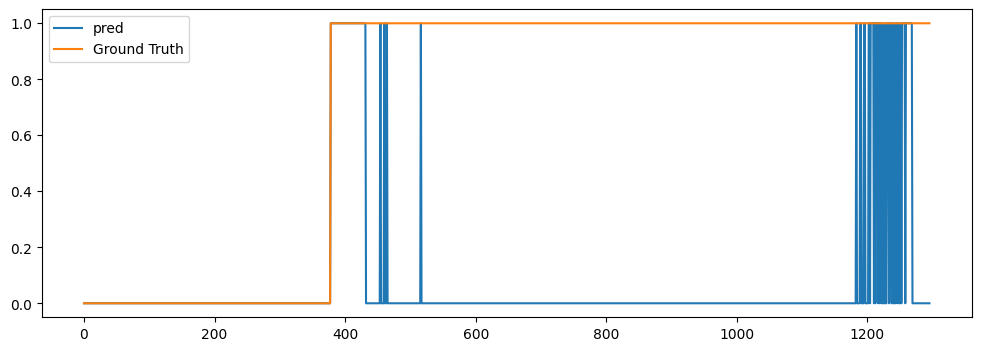

In [123]:
fig = plt.figure(figsize=(12, 4))
plt.plot(pred, label='pred')
plt.plot(ground_truth, label='Ground Truth')
plt.legend()
plt.show()

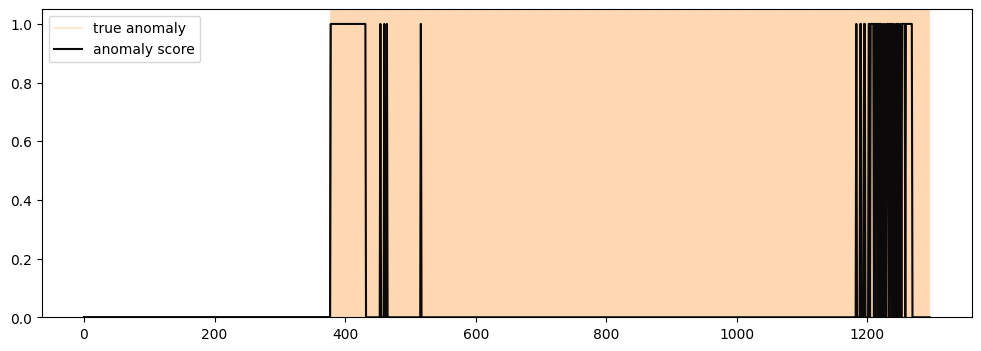

In [124]:
check_graph(pred, np.array(ground_truth))
plt.show()

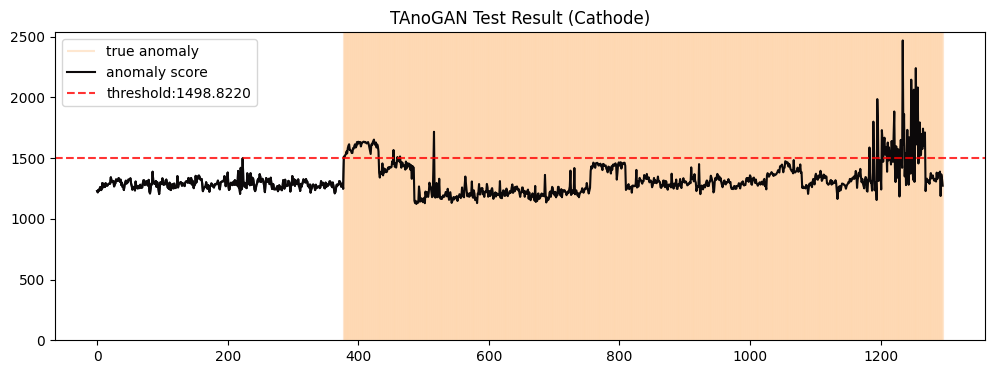

In [125]:
check_graph(anomaly_score, ground_truth,1,threshold)
plt.title('TAnoGAN Test Result (Cathode)')
plt.show()

In [127]:
bead_counter = []
for i in range(len(pred)//54):
    bead_counter.append(dict(Counter(pred[i*54: (i+1)*54])))
print(bead_counter)

[{0: 54}, {0: 54}, {0: 54}, {0: 54}, {0: 54}, {0: 54}, {0: 54}, {1: 54}, {0: 51, 1: 3}, {0: 53, 1: 1}, {0: 54}, {0: 54}, {0: 54}, {0: 54}, {0: 54}, {0: 54}, {0: 54}, {0: 54}, {0: 54}, {0: 54}, {0: 54}, {0: 53, 1: 1}, {0: 25, 1: 29}, {0: 34, 1: 20}]


In [88]:
abnormal_index = pd.DataFrame(bead_counter)[[1]].fillna(0).astype(int)
abnormal_index.columns = ['Abnormal']
abnormal_index.to_csv('Beads_Abnormal_count(TAnoGAN_Cathode).csv', index = True)

### Threshold Sensitivity

In [ ]:
thres = []
f1_ = []
prec = []
recall_ = []
precision_thres = []

for th in np.linspace(float(min(result['score'])), float(max(result['score'])),10000):

    thres.append(th)
    f1_.append(f1)
    prec.append(precision)
    recall_.append(recall)

    f1, precision, recall, _, _, _, _, auroc, _ =  calc_seq(result['score'], result['true_label'], th, 100, False)

    if precision >= 0.9:
        precision_thres.append(th)

    print(f'F1: {f1:.4f}, Prec: {precision:.4f}, Recall: {recall:.4f}')
    
metrics = pd.DataFrame([thres, f1_, prec, recall_]).T
metrics.columns = ['threshold', 'f1', 'precision', 'recall']

In [26]:
# Threshold when Precision > 0.9

pred = (anomaly_score>precision_thres[0]).astype(int)

tn, fp, fn, tp = confusion_matrix(ground_truth, pred).ravel()
(tn, fp, fn, tp)

f1, precision, recall, _, _, _, _, auroc, _ =  calc_seq(result['score'], result['true_label'], precision_thres[0], 100, False)

print(f'AUROC: {auroc:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

AUROC: 0.5654, F1: 0.4104, Precision: 0.9004, Recall: 0.2658


Text(0.5, 0.01, 'Threshold')

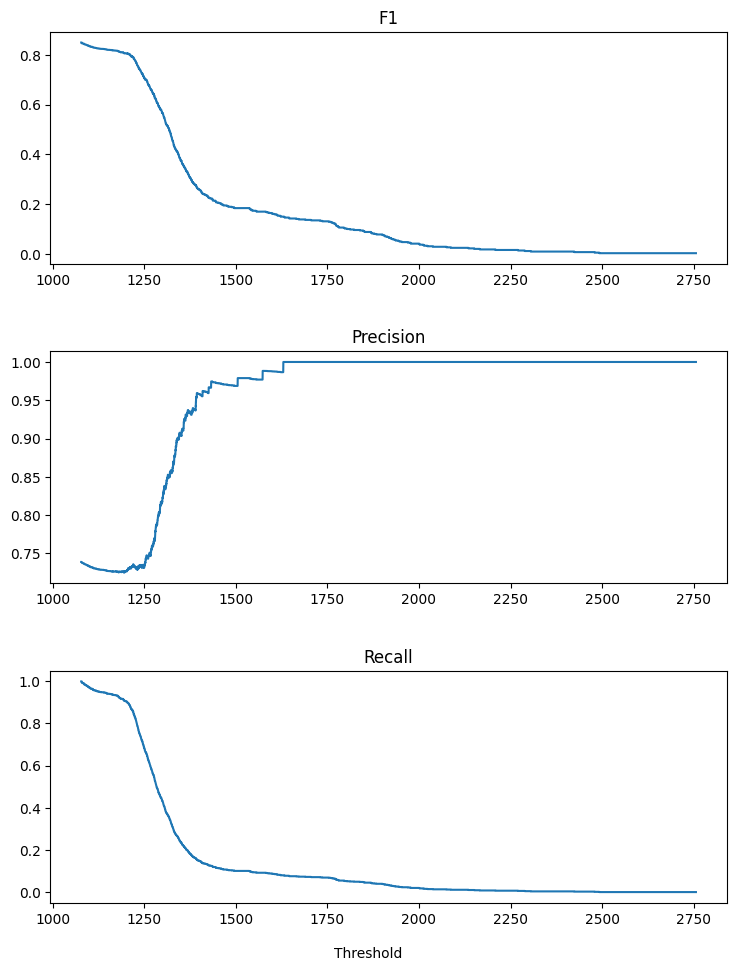

In [27]:
import matplotlib.pyplot as plt
import numpy as np

x = np.array(metrics['threshold'])
y1 = np.array(metrics['f1'])
y2 = np.array(metrics['precision'])
y3 = np.array(metrics['recall'])

# Create a figure with three subplots
fig, axs = plt.subplots(3, 1, figsize=(8, 10))

# Plot the data on each subplot
axs[0].plot(x, y1)
axs[0].set_title('F1')
axs[1].plot(x, y2)
axs[1].set_title('Precision')
axs[2].plot(x, y3)
axs[2].set_title('Recall')

# Add a common x-axis label and adjust the spacing between subplots
fig.tight_layout(pad=3.0)
fig.text(0.5, 0.01, 'Threshold', ha='center')

In [89]:
from extract_rule_based_features import ExtractFeatures, detect_bead

def slice_bead_data(path, set_bead_100=False):
    "path: data 저장 경로 (str)"
    extractor = ExtractFeatures(path)
    data = extractor.data
    if 'Abnormal' in path:
        data['label'] = 1
        data['dataset_idx'] = path[-12:-10]
    else:
        data['label'] = 0
        data['dataset_idx'] = str(path).split('/')[-1].split('.')[0]
    bead_array = detect_bead(data['LO'])
    data['bead_num'] = '0'
    
    if not set_bead_100:
        total_data = data.iloc[bead_array[0][0]:bead_array[0][1]+1]
    else:
        total_data = data.iloc[bead_array[0][0]:bead_array[0][0]+100]
    
    if 'Abnormal' in path:
        total_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(0)
    
    else:
        total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)

    if not set_bead_100:
        for i in range(1, len(bead_array)):
            bead_data = data.iloc[bead_array[i][0]:bead_array[i][1]]
            bead_data['bead_num'] = str(i)
            if 'Abnormal' in path:
                bead_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(i)
            
            else:
                bead_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(i)
                
            total_data = pd.concat([total_data, bead_data])

    else:
        for i in range(1, len(bead_array)):
            bead_data = data.iloc[bead_array[i][0]:bead_array[i][0]+100]
            bead_data['bead_num'] = str(i)
            if 'Abnormal' in path:
                bead_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(i)
            
            else:
                bead_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(i)
                
            total_data = pd.concat([total_data, bead_data])
                
    return total_data

In [ ]:
Cathode_Normal = sorted([x for x in Path("../data/230507/Cathode/Normal").glob("*.csv")])
Cathode_Abnormal = sorted([x for x in Path("../data/230507/Cathode/Abnormal").glob("*.csv")])

data_folder_list = Cathode_Normal + Cathode_Abnormal
num_train_dataset = 24

Cathode_Train = pd.DataFrame(columns=['LO', 'BR', 'NIR', 'VIS', 'label','dataset_idx','bead_num'])
Cathode_Test = pd.DataFrame(columns=['LO', 'BR', 'NIR', 'VIS', 'label','dataset_idx','bead_num'])

for i in range(num_train_dataset):
    bead_i = slice_bead_data(str(data_folder_list[i]),set_bead_100=True)
    Cathode_Train = pd.concat([Cathode_Train, bead_i])

for i in range(num_train_dataset, len(data_folder_list)):
    bead_i = slice_bead_data(str(data_folder_list[i]),set_bead_100=True)
    Cathode_Test = pd.concat([Cathode_Test, bead_i])

In [98]:
import json
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.preprocessing import StandardScaler

class create_dataset(Dataset):
    
    def __init__(
                self, train_data, test_data, 
                feature_names : list, 
                window_length: int = 100, step_size: int = 100, 
                mode:str = 'train'
                ):
        
        super(create_dataset, self).__init__()

        self.window_length = window_length
        self.step_size = step_size

        train_label = train_data['label'].values
        test_label = test_data['label'].values

        self.scaler = StandardScaler()

        train_data = self.scaler.fit_transform(train_data[feature_names])
        test_data = self.scaler.transform(test_data[feature_names].values)

        self.data = train_data if mode == 'train' else test_data
        self.label = train_label if mode == 'train' else test_label

        self.data = np.float32(self.data)
        self.label = np.float32(self.label)
        
    def __len__(self):
        
        return (self.data.shape[0] - self.window_length) // self.step_size + 1
    
    def __getitem__(self, idx):
        
        idx = idx * self.step_size

        xx = self.data[idx:idx+self.window_length]
        yy = self.label[idx:idx+self.window_length]
                
        return xx, yy

In [99]:
import torch.nn as nn
import torch

class Dis(nn.Module):
    def __init__(self, in_dim, hidden_size):
        super(Dis, self).__init__()

        self.in_dim = in_dim
        self.hidden_size = hidden_size

        self.layer1 = nn.LSTM(in_dim, hidden_size=hidden_size, num_layers = 1, batch_first = True)
        self.linear = nn.Sequential(nn.Linear(hidden_size, 1), nn.Sigmoid())

    def forward(self, x, h_0, c_0):

        batch_size, window_size = x.size(0), x.size(1)
        out, _ = self.layer1(x, (h_0, c_0))
        output = out.reshape(batch_size * window_size, self.hidden_size)

        output = self.linear(output).reshape(batch_size, window_size, 1)

        return output, out

In [100]:
class Gen(nn.Module):

    def __init__(self, in_dim, window_size):

        super(Gen,self).__init__()

        self.in_dim = in_dim
        self.window_size = window_size
        self.layer1 = nn.LSTM(in_dim, hidden_size = 32, num_layers = 1, batch_first = True) #stack of 3 LSTM with different hidden size
        self.layer2 = nn.LSTM(32, hidden_size = 64, num_layers = 1, batch_first = True)
        self.layer3 = nn.LSTM(64, hidden_size = 128, num_layers = 1, batch_first = True)
        self.FC = nn.Sequential(nn.Linear(128, in_dim), nn.Tanh())

    def forward(self, x, h_0, c_0):
        
        batch_size, window_size = x.size(0), x.size(1)
        out, _ = self.layer1(x, (h_0, c_0))
        out, _ = self.layer2(out)
        out, _ = self.layer3(out)

        FC_input = out.reshape(batch_size * window_size, 128)

        output = self.FC(FC_input)

        output = output.reshape(batch_size, window_size, self.in_dim)

        return output, out

In [101]:
feature_names = ['LO','BR',	'NIR','VIS']

train_dataset = create_dataset(Cathode_Train, Cathode_Test, feature_names,
                          100,100,'train')

test_dataset = create_dataset(Cathode_Train, Cathode_Test, feature_names,
                          100,100,'test')

train_loader = DataLoader(train_dataset, 32, shuffle = True)

test_loader = DataLoader(test_dataset, 1, shuffle = False)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

torch_seed(77)

gen_model = Gen(in_dim=4, window_size = 100)
gen_model.to(device)
dis_model = Dis(in_dim=4, hidden_size = 100)
dis_model.to(device)

criterion = torch.nn.BCELoss()
optimizer_g = torch.optim.Adam(params=gen_model.parameters(), lr = 1e-3)
optimizer_d = torch.optim.Adam(params=dis_model.parameters(), lr = 1e-3)

In [102]:
import torch
import torch.nn as nn
import logging
import wandb
import time
import pdb
import torch.nn.init as init
from torch.autograd import Variable
from collections import OrderedDict
import os
import json

_logger = logging.getLogger('train')

class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def train(gen, dis, train_loader, 
    optimizer_G, optimizer_D, criterion, device,
    log_interval
    ):

    batch_time_m = AverageMeter()
    data_time_m = AverageMeter()
    acc_d_real_m = AverageMeter()
    acc_d_fake_m = AverageMeter()
    acc_g_m = AverageMeter()

    losses_d_real_m = AverageMeter()
    losses_d_fake_m = AverageMeter()
    losses_g_m = AverageMeter()
    losses_d_m = AverageMeter()

    end = time.time()

    losses = []
    losses_d = []

    dis.train()
    gen.train()

    optimizer_G.zero_grad()
    optimizer_D.zero_grad()

    for idx, (xx, _) in enumerate(train_loader):

        # Train Discriminator
        
        batch_size, window_size, in_dim = xx.size(0), xx.size(1), xx.size(2)

        optimizer_D.zero_grad()

        label = torch.ones((batch_size, window_size, 1)).to(device)
        label_size = label.flatten().shape[0]

        xx = xx.to(device)

        h_0, c_0 = torch.zeros(1, batch_size, dis.hidden_size).to(device), torch.zeros(1, batch_size, dis.hidden_size).to(device)
        h_g_0, c_g_0 = torch.zeros(1, batch_size, 32).to(device), torch.zeros(1, batch_size, 32).to(device)

        output,_ = dis(xx, h_0, c_0)
        
        loss_D_real = criterion(output, label)
        loss_D_real.backward()

        losses_d_real_m.update(loss_D_real.item())

        optimizer_D.step()

        preds = torch.round(output).detach().cpu()

        acc_d_real_m.update(label.detach().cpu().eq(preds).sum().item()/label_size, n=label_size)

        noise = Variable(init.normal(torch.Tensor(batch_size,window_size,in_dim),mean=0,std=0.1)).to(device)
        fake, _ = gen(noise, h_g_0, c_g_0)

        output, _ = dis(fake.detach(), h_0, c_0)

        label = torch.zeros((batch_size, window_size, 1)).to(device)
        
        loss_d_fake = criterion(output, label)
        loss_d_fake.backward()

        losses_d_fake_m.update(loss_d_fake.item())
        loss_dis = loss_d_fake + loss_D_real
        optimizer_D.step()

        losses_d_m.update(loss_dis.item())

        preds = torch.round(output).detach().cpu()

        acc_d_fake_m.update(label.detach().cpu().eq(preds).sum().item()/label_size, n=label_size)

        # Train Generator
        optimizer_G.zero_grad()
        noise = Variable(init.normal(torch.Tensor(batch_size,window_size,in_dim),mean=0,std=0.1)).to(device)
        fake, _ = gen(noise, h_g_0, c_g_0)
        
        label = torch.ones((batch_size, window_size, 1)).to(device)
        output, _ = dis(fake, h_0, c_0)

        loss_g = criterion(output, label)
        loss_g.backward()

        losses_g_m.update(loss_g.item())

        optimizer_G.step()

        preds = torch.round(output).detach().cpu()
        acc_g_m.update(label.detach().cpu().eq(preds).sum().item()/label_size, n=label_size)

        losses.append(loss_g.item())
        losses_d.append(loss_dis.item())

        if idx % log_interval == 0 and idx != 0:

            _logger.info('TRAIN Iteration: [{:>4d}/{}] \n'
                        'Loss D Real: {losses_d_real.val:>6.4f} ({losses_d_real.avg:>6.4f}) '
                        'Acc D Real: {acc_d_real.avg:.3%} \n'
                        'Loss D Fake: {losses_d_fake.val:>6.4f} ({losses_d_fake.avg:>6.4f}) '
                        'Acc D Fake: {acc_d_fake.avg:.3%} \n'
                        'Loss D: {loss_dis:.3f} \n'
                        'Loss G: {losses_g.val:>6.4f} ({losses_g.avg:>6.4f}) '
                        'Acc G: {acc_g.avg:.3%} \n'
                        'LR: {lr:.3e} \n'.format(
                        idx+1, len(train_loader), 
                        losses_d_real = losses_d_real_m,
                        acc_d_real = acc_d_real_m,
                        losses_d_fake = losses_d_fake_m,
                        acc_d_fake = acc_d_fake_m,
                        loss_dis = loss_dis.item(),
                        losses_g = losses_g_m,
                        acc_g = acc_g_m,
                        lr    = optimizer_D.param_groups[0]['lr'],
                        )
            )

        end = time.time()

    return OrderedDict([('acc_d_real',acc_d_real_m.avg), ('loss_d_real',losses_d_real_m.avg),
                        ('acc_d_fake',acc_d_fake_m.avg), ('loss_d_real',losses_d_fake_m.avg),
                        ('acc_g',acc_g_m.avg), ('loss_g',losses_g_m.avg), ('loss_d', losses_d_m.avg)
                        ])

In [103]:
from tqdm import tqdm
epochs = 20

for epoch in tqdm(range(epochs)):

    train_metrics = train(
                        gen = gen_model, dis = dis_model, train_loader = train_loader, optimizer_G = optimizer_g,
                        optimizer_D = optimizer_d, criterion = criterion, device = device, log_interval = 1
                        )

    print(train_metrics)

    metrics = OrderedDict(lr=optimizer_d.param_groups[0]['lr'])
    metrics.update([('train_' + k, v) for k, v in train_metrics.items()])

  0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_687341/2233510621.py:89: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  noise = Variable(init.normal(torch.Tensor(batch_size,window_size,in_dim),mean=0,std=0.1)).to(device)
/tmp/ipykernel_687341/2233510621.py:111: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  noise = Variable(init.normal(torch.Tensor(batch_size,window_size,in_dim),mean=0,std=0.1)).to(device)
  5%|▌         | 1/20 [00:01<00:34,  1.83s/it]

OrderedDict([('acc_d_real', 0.7829012345679013), ('loss_d_real', 1.0233294731233178), ('acc_d_fake', 0.07740740740740741), ('acc_g', 0.9450617283950618), ('loss_g', 0.576168484077221), ('loss_d', 1.480101631908882)])


 10%|█         | 2/20 [00:03<00:31,  1.76s/it]

OrderedDict([('acc_d_real', 0.6360030864197531), ('loss_d_real', 0.8491616830593203), ('acc_d_fake', 0.06517746913580247), ('acc_g', 0.9144212962962963), ('loss_g', 0.5768472472342049), ('loss_d', 1.453669004324006)])


 15%|█▌        | 3/20 [00:05<00:29,  1.72s/it]

OrderedDict([('acc_d_real', 0.9914274691358025), ('loss_d_real', 0.7280746131408505), ('acc_d_fake', 0.4546604938271605), ('acc_g', 0.48618827160493827), ('loss_g', 0.7049414544570737), ('loss_d', 0.8718511069693217)])


 20%|██        | 4/20 [00:06<00:27,  1.71s/it]

OrderedDict([('acc_d_real', 0.9986805555555556), ('loss_d_real', 0.20612443320271445), ('acc_d_fake', 1.0), ('acc_g', 0.0), ('loss_g', 2.087836016968983), ('loss_d', 0.2230486949769462)])


 25%|██▌       | 5/20 [00:08<00:25,  1.69s/it]

OrderedDict([('acc_d_real', 0.9994830246913581), ('loss_d_real', 0.04957881933305322), ('acc_d_fake', 1.0), ('acc_g', 0.0), ('loss_g', 3.8637395428448187), ('loss_d', 0.05942721601303031)])


 30%|███       | 6/20 [00:10<00:23,  1.69s/it]

OrderedDict([('acc_d_real', 0.9995679012345678), ('loss_d_real', 0.0483108990621276), ('acc_d_fake', 1.0), ('acc_g', 0.0), ('loss_g', 4.348611168745087), ('loss_d', 0.05579265316085118)])


 35%|███▌      | 7/20 [00:11<00:21,  1.69s/it]

OrderedDict([('acc_d_real', 0.999266975308642), ('loss_d_real', 0.03069616885992085), ('acc_d_fake', 1.0), ('acc_g', 0.0), ('loss_g', 5.145848588245671), ('loss_d', 0.038084387097780295)])


 40%|████      | 8/20 [00:13<00:20,  1.70s/it]

OrderedDict([('acc_d_real', 0.9997608024691358), ('loss_d_real', 0.024515455724989494), ('acc_d_fake', 1.0), ('acc_g', 0.0), ('loss_g', 5.650540979897103), ('loss_d', 0.02884430479167438)])


 45%|████▌     | 9/20 [00:15<00:18,  1.69s/it]

OrderedDict([('acc_d_real', 0.9998919753086419), ('loss_d_real', 0.021103277893328085), ('acc_d_fake', 1.0), ('acc_g', 0.0), ('loss_g', 6.075975615803788), ('loss_d', 0.024314668392989694)])


 50%|█████     | 10/20 [00:17<00:16,  1.69s/it]

OrderedDict([('acc_d_real', 1.0), ('loss_d_real', 0.022061309936206516), ('acc_d_fake', 1.0), ('acc_g', 0.0), ('loss_g', 6.395341384701613), ('loss_d', 0.024294915586346534)])


 55%|█████▌    | 11/20 [00:18<00:15,  1.68s/it]

OrderedDict([('acc_d_real', 1.0), ('loss_d_real', 0.022379186685855795), ('acc_d_fake', 1.0), ('acc_g', 0.0), ('loss_g', 6.696045922070015), ('loss_d', 0.024398615947220384)])


 60%|██████    | 12/20 [00:20<00:13,  1.68s/it]

OrderedDict([('acc_d_real', 0.9999768518518518), ('loss_d_real', 0.019080738832310932), ('acc_d_fake', 1.0), ('acc_g', 0.0), ('loss_g', 6.991568158312542), ('loss_d', 0.021016820129461405)])


 65%|██████▌   | 13/20 [00:22<00:11,  1.69s/it]

OrderedDict([('acc_d_real', 1.0), ('loss_d_real', 0.018043307269491802), ('acc_d_fake', 1.0), ('acc_g', 0.0), ('loss_g', 7.233563178923072), ('loss_d', 0.019851405764134918)])


 70%|███████   | 14/20 [00:23<00:10,  1.69s/it]

OrderedDict([('acc_d_real', 1.0), ('loss_d_real', 0.02101283434142427), ('acc_d_fake', 1.0), ('acc_g', 0.0), ('loss_g', 7.435324099005722), ('loss_d', 0.022754898930831654)])


 75%|███████▌  | 15/20 [00:25<00:08,  1.69s/it]

OrderedDict([('acc_d_real', 1.0), ('loss_d_real', 0.01804885858806168), ('acc_d_fake', 1.0), ('acc_g', 0.0), ('loss_g', 7.669870865054246), ('loss_d', 0.01992394552543396)])


 80%|████████  | 16/20 [00:27<00:06,  1.69s/it]

OrderedDict([('acc_d_real', 1.0), ('loss_d_real', 0.015176225839773329), ('acc_d_fake', 1.0), ('acc_g', 0.0), ('loss_g', 7.888816054274396), ('loss_d', 0.01704641081756208)])


 85%|████████▌ | 17/20 [00:28<00:05,  1.70s/it]

OrderedDict([('acc_d_real', 1.0), ('loss_d_real', 0.0133313840346002), ('acc_d_fake', 1.0), ('acc_g', 0.0), ('loss_g', 8.082566319442376), ('loss_d', 0.015069167016119493)])


 90%|█████████ | 18/20 [00:30<00:03,  1.70s/it]

OrderedDict([('acc_d_real', 1.0), ('loss_d_real', 0.012191411198639288), ('acc_d_fake', 1.0), ('acc_g', 0.0), ('loss_g', 8.265934758070038), ('loss_d', 0.013717893374765791)])


 95%|█████████▌| 19/20 [00:32<00:01,  1.70s/it]

OrderedDict([('acc_d_real', 1.0), ('loss_d_real', 0.011483527947126366), ('acc_d_fake', 1.0), ('acc_g', 0.0), ('loss_g', 8.44861039882753), ('loss_d', 0.012822143847077357)])


100%|██████████| 20/20 [00:33<00:00,  1.70s/it]

OrderedDict([('acc_d_real', 1.0), ('loss_d_real', 0.010664491141896422), ('acc_d_fake', 1.0), ('acc_g', 0.0), ('loss_g', 8.623737242163681), ('loss_d', 0.011855773059878408)])


In [104]:
dis_loss_cand = train_metrics['loss_d']
gen_loss_cand = train_metrics['loss_g']

In [105]:
import torch
from torch.autograd import Variable
import torch.nn.init as init
import pandas as pd
import os
import logging
import pdb

_logger = logging.getLogger('Optimization')

def Anomaly_score(latent, fake, latent_interm, fake_interm, Lambda=0.1):
    residual_loss = torch.sum(torch.abs(latent-fake)) # Residual Loss
    
    discrimination_loss = torch.sum(torch.abs(latent_interm-fake_interm)) # Discrimination loss
    
    total_loss = (1-Lambda)*residual_loss + Lambda*discrimination_loss
    return total_loss

def optimize(save_dir, dis, gen, test_loader, window_size, 
             in_dim, Lambda, iterations, device, log_interval):

    anomaly_score = []
    y_label = []
    #actual_obs = []
    test_anomaly_score = pd.DataFrame()

    dis.eval()
    gen.eval()

    torch.backends.cudnn.enabled = False
    
    for idx, (xx,yy) in enumerate(tqdm(test_loader)):

        y_label.append(yy[0][0].detach().item())
        #actual_obs.append(xx.flatten()[window_size-1].detach().item())

        xx = xx.to(device)
        batch_size = xx.size(0)

        h_0, c_0 = torch.zeros(1, batch_size, dis.hidden_size).to(device), torch.zeros(1, batch_size, dis.hidden_size).to(device)
        h_g_0, c_g_0 = torch.zeros(1, batch_size, 32).to(device), torch.zeros(1, batch_size, 32).to(device)

        z = Variable(init.normal(torch.zeros(batch_size, window_size, in_dim, device=device),mean = 0, std = 0.1),
                    requires_grad = True)

        z_optimizer =  torch.optim.Adam([z],lr = 0.01)
        
        _logger.info(f'\n Batch: {idx+1}/{len(test_loader)}')

        for iter in range(iterations):
            fake, _ = gen(z, h_g_0, c_g_0)
            _, x_feature = dis(xx, h_0, c_0) 
            _, G_z_feature = dis(fake, h_0, c_0) 

            loss = Anomaly_score(xx.detach(), fake, x_feature.detach(), G_z_feature, Lambda = Lambda)
            
            z_optimizer.zero_grad()
            loss.backward()
            z_optimizer.step()
            
        _logger.info('Batch [{}/{}]: Anomaly Score: {:.3f} label: {}'.format(idx+1, len(test_loader), loss.item(),yy[0][0].detach().item()))
                                                                                        
        anomaly_score.append(loss.item())

    #test_anomaly_score['actual_obs'] = actual_obs
    test_anomaly_score['score'] = anomaly_score
    test_anomaly_score['true_label'] = y_label

    test_anomaly_score.to_csv(save_dir,index=False)

In [109]:
save_dir = '/workspace/Project_LG_Welding_AD/src'
df_dir = os.path.join(save_dir,'Test_AD_results_Cathode.csv')

optimize(
        save_dir=df_dir,
        dis=dis_model,gen = gen_model, 
        test_loader = test_loader,
        window_size= 100,
        in_dim = 4,
        Lambda = 0.1,
        iterations = 50,
        device = device, 
        log_interval = int(50/5),
        )

  0%|          | 0/1296 [00:00<?, ?it/s]/tmp/ipykernel_687341/1265353997.py:43: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  z = Variable(init.normal(torch.zeros(batch_size, window_size, in_dim, device=device),mean = 0, std = 0.1),
100%|██████████| 1296/1296 [07:47<00:00,  2.77it/s]
